# Data Transformation

In [9]:
# First we import all neccessary libraries and give some of them an alias for easy access
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from skrebate import ReliefF
from sklearn.preprocessing import StandardScaler

In [10]:
# Read in the data so every group member can run the notebook on his machine
# (our repo is on github, we therefore have the same file structure)
df = pd.read_csv("../../Data/Transformed/Leo/inventory_management_cleaned.csv")
df.shape # Get a first idea about the number of rows and columns of the dataset

(1722, 10)

In [11]:
# Get a first impression about our data
df.head()

,Category,Region,Inventory Level,Price,Discount,Weather Condition,Promotion,Demand,Product_UID,Weekday
0,Electronics,North,195,72.72,5,Snowy,0,115,S001_P0001,Saturday
1,Clothing,North,117,80.16,15,Snowy,1,229,S001_P0002,Saturday
2,Clothing,North,247,62.94,10,Snowy,1,157,S001_P0003,Saturday
3,Electronics,North,139,87.63,10,Snowy,0,52,S001_P0004,Saturday
4,Groceries,North,152,54.41,0,Snowy,0,59,S001_P0005,Saturday


In [12]:
# Now we encode everything so that ML algorithms can perform on the data
label_encoders = {}

# Columns that need to be encoded
cols_to_encode = ["Region", "Weather Condition", "Category", "Weekday"]

# Encode each column and store the encoder
for col in cols_to_encode:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Save the encoder

# Have a look at the encoded dataframe
df.head()

,Category,Region,Inventory Level,Price,Discount,Weather Condition,Promotion,Demand,Product_UID,Weekday
0,1,1,195,72.72,5,1,0,115,S001_P0001,2
1,0,1,117,80.16,15,1,1,229,S001_P0002,2
2,0,1,247,62.94,10,1,1,157,S001_P0003,2
3,1,1,139,87.63,10,1,0,52,S001_P0004,2
4,3,1,152,54.41,0,1,0,59,S001_P0005,2


In [13]:
# Save the label_encoders mappings as a text file
with open('../../Data/Transformed/Leo/label_encodings.txt', 'w') as f:
    for col, encoder in label_encoders.items():
        f.write(f"{col}:\n")
        for idx, label in enumerate(encoder.classes_):
            f.write(f"  {label}: {idx}\n")
        f.write("\n")

In [14]:
# We store the cleaned data with the unscaled values for the decision tree
df.to_csv("../../Data/Transformed/Leo/inventory_management_cleaned_transformed_unscaled.csv", index=False)

In [15]:
# We scale the columns for kmeans
# We used the StandardScaler because it produces better results in our case
scale_columns = [
    "Inventory Level",
    "Price",
    "Discount",
    "Demand",
]

df_scaled = df.copy()
scaler = StandardScaler()
df_scaled[scale_columns] = scaler.fit_transform(df[scale_columns])


In [16]:
# Use the ReliefF Algorithm to get insights in the feature importance, this can only be applied after all values are encoded and fits well
# in this scenario due to our binary classification problem
# Separate target variable and features
X = df_scaled.drop(['Promotion', 'Product_UID'], axis=1) 
y = df_scaled['Promotion']  

# Apply the algorithm
relieff = ReliefF(n_neighbors=100, n_features_to_select=X.shape[1])
relieff.fit(X.values, y.values)

# Output the feature importance scores
scores = pd.Series(relieff.feature_importances_, index=X.columns)
print("Feature Importance Scores (sorted):")
print(scores.sort_values(ascending=False))

Feature Importance Scores (sorted):
Discount             0.438269
Demand               0.070137
Weekday              0.016736
Weather Condition    0.009756
Inventory Level     -0.001802
Region              -0.008531
Price               -0.008930
Category            -0.015221
dtype: float64


In [17]:
# We store the cleaned data with the scaled values for kmeans
df_scaled.to_csv("../../Data/Transformed/Leo/inventory_management_cleaned_transformed.csv", index=False)

Saved table image to: ../../Images/Challenge_interpretable_data_set.png


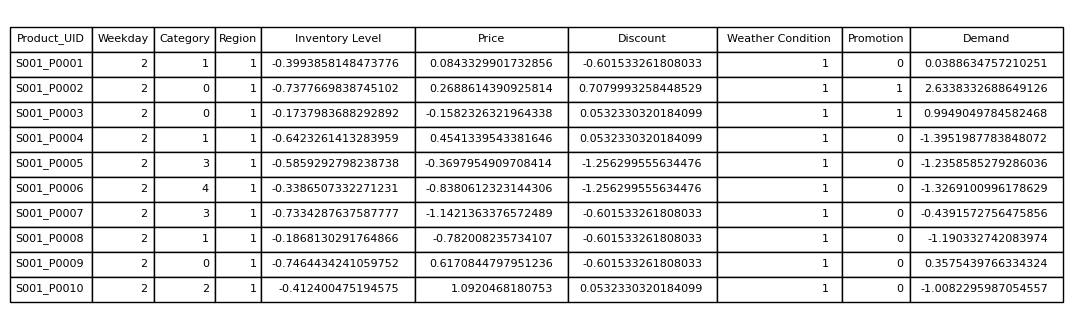

In [ ]:
# This is only to store some data tables for our presentation
import matplotlib.pyplot as plt
import matplotlib.table as tbl
import os

# Load the transformed dataset
file_path = "../../Data/Transformed/Leo/inventory_management_cleaned_transformed.csv"
df_scaled = pd.read_csv(file_path)

# Take the first 10 rows
sample_top10 = df_scaled.head(10)

# Optionally reorder columns (example: bring Product_UID & Weekday to front if they exist)
cols = sample_top10.columns.tolist()
for c in ['Product_UID', 'Weekday']:
    if c in cols:
        cols.remove(c)
new_order = [c for c in ['Product_UID', 'Weekday'] if c in sample_top10.columns] + cols
sample_top10 = sample_top10[new_order]

# Create figure and hide axes
fig, ax = plt.subplots(figsize=(10, 4))
ax.axis('off')

# Create and format table
table = tbl.table(
    ax,
    cellText=sample_top10.values,
    colLabels=sample_top10.columns,
    loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.2, 1.5)

# Adjust column widths if supported
try:
    table.auto_set_column_width(col=list(range(sample_top10.shape[1])))
except AttributeError:
    pass  # older matplotlib versions

# Save the table as a high-DPI PNG
output_dir = "../../Images"
os.makedirs(output_dir, exist_ok=True)
image_path = os.path.join(output_dir, "Challenge_interpretable_data_set.png")
plt.savefig(image_path, bbox_inches='tight', dpi=700)

print(f"Saved table image to: {image_path}")
